### try to generate slice positions in ra and dec for oskar visibilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const
import glob
from scepter import skynet,obs,tlefinder
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz, ICRS
from matplotlib.gridspec import GridSpec
from matplotlib import animation


In [2]:
tm_dir="OSKAR-2.7-Example-Data/"
telescope_model_position=tm_dir+"telescope.tm/position.txt"
tle_dir="example_tle/20250407_035542.npz"
### generate pyobserver with telescope model position

pos=np.loadtxt(telescope_model_position)
if len(pos.shape)==3:
    lon,lat,alt=pos
    alt=alt*1000 ### to km
else:
    lon,lat=pos
    alt=0
cen_obs=cysgp4.PyObserver(lon,lat,alt)

location = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m)


In [ ]:
min_elevation = 0 * u.deg
grid_size = 2. * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(min_elevation, 90 * u.deg),
    rnd_seed=0,
    )

tel_az, tel_el, grid_info = skygrid 

### only generating for one continous observation, change epoch and day if needed
mjds = skynet.plantime(epochs=1,cadence=1*u.day,trange=2000*u.s,tint=1*u.s)
print(mjds.shape)
time = Time(mjds, format='mjd')


(1, 1, 1, 1, 2000, 1)


In [4]:
tles=tlefinder.readtlenpz(tle_dir) ### read a random tle

tles.shape

(7191,)

In [23]:
result = cysgp4.propagate_many(mjds,tles[:1000],observers=[cen_obs],do_eci_pos=False, do_topo=True, do_obs_pos=True, do_sat_azel=False,sat_frame='zxy') 
tel_az,tel_el,dist=tlefinder.parse_sgp4info(result,frame='topo')

In [ ]:
### convert to ra and dec using astropy
altaz = AltAz(alt=tel_el*u.deg, az=tel_az*u.deg, obstime=time, location=location)
skycoord = SkyCoord(altaz)

skycoord=skycoord.flatten()
print(skycoord.shape)

In [31]:

ra = skycoord.icrs.ra.deg
dec = skycoord.icrs.dec.deg
ra = ra.reshape(tel_az.shape)
dec = dec.reshape(tel_az.shape)

In [35]:
np.savez('oskar_radec.npz', ra=ra, dec=dec,time=mjds,alt=tel_el,az=tel_az,dist=dist)

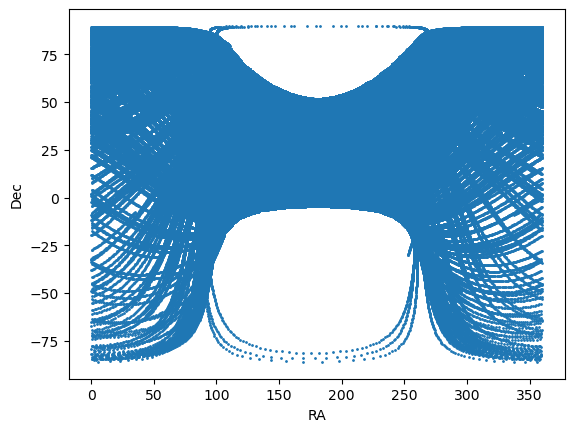